In [1]:
%matplotlib inline

import numpy as np
from dolfin import *
from mshr import *

import matplotlib.pyplot as plt

# Do not reorder degrees of freedom (dofs)
parameters['reorder_dofs_serial'] = False
# Extrapolate values to produce smoother representations
parameters['allow_extrapolation'] = True

## Solve Heat equation on a disk

### Step 1: Define the Domain

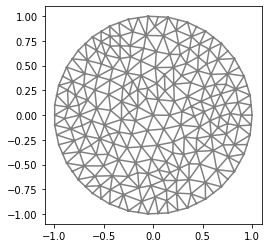

In [2]:
domain = Circle(Point(.0,.0), 1)
disk_mesh = generate_mesh(domain, 10)
plot(disk_mesh)

### Step 2: Define the Function Space

In [3]:
# The basis functions are Lagrange polynomials of order 1 (i.e. linear functions)
FS_disk = FunctionSpace(disk_mesh, 'Lagrange', 1)

u = TrialFunction(FS_disk)
v = TestFunction(FS_disk)

### Step 3: Define the Boundary Conditions

In [4]:
def disk_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and near(np.sqrt(x**2 + y**2), 1, 5e-2)

BC_disk = DirichletBC(FS_disk, Constant(1), disk_boundary)

### Step 4: Define the Equation

In [5]:
left_integrand = inner(nabla_grad(u), nabla_grad(v)) * dx
f =  Expression("x[0]*x[0]/2 + x[1]*x[1]", degree=1)
right_integrand = f*v*dx

### Step 5: Assemble and Solve the Problem

In [6]:
#set up linear algebra problem
A = assemble(left_integrand)
b = assemble(right_integrand)
BC_disk.apply(A,b)
disk_sol = Function(FS_disk) # placeholder for solution
solve(A, disk_sol.vector(), b)

1

### Step 6: Visualize the Results

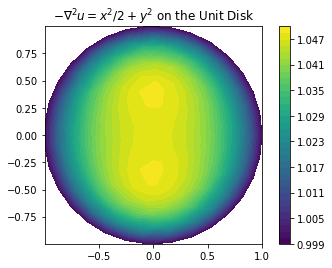

In [7]:
# Default visualization with the addition of a colorbar
p = plot(disk_sol)
plt.title(r'$-∇ ^2 u = x^2/2+y^2$ on the Unit Disk')
plt.colorbar(p)
plt.show()

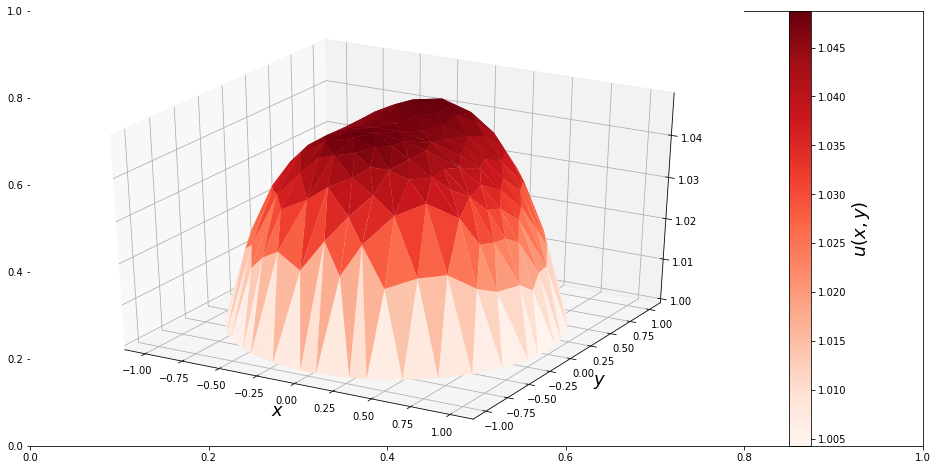

In [8]:
import matplotlib as mpl

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

def mesh_triangulation(mesh):
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    return mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)

triangulation = mesh_triangulation(disk_mesh)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
c = ax.plot_trisurf(triangulation, np.array(disk_sol.vector()),cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax)
cb.set_label(r"$u(x, y)$", fontsize=18)


## Solve on Perforated Disk

### Step 1: Define the Domain

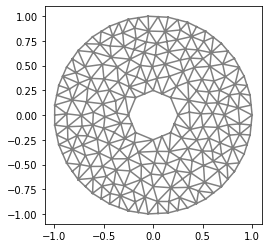

In [9]:
r_outer = 1
r_inner = 0.25
wedge = Circle(Point(.0, .0), r_outer) - Circle(Point(.0, .0), r_inner)
wedge_mesh = generate_mesh(wedge, 10)
plot(wedge_mesh)

### Step 2: Define the Function Space

In [10]:
FS_wedge = FunctionSpace(wedge_mesh, 'Lagrange', 1)
u = TrialFunction(FS_wedge)
v = TestFunction(FS_wedge)

### Step 3: Define the Boundary Conditions

In [11]:
def inner_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and near(np.sqrt(x**2 + y**2),r_inner, 5e-2)

def outer_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and near(np.sqrt(x**2 + y**2),r_outer, 5e-2)

boundary = [DirichletBC(FS_wedge, Constant(5), inner_boundary),
           DirichletBC(FS_wedge, Constant(0), outer_boundary)]

### Step 4: Define the Equation

In [12]:
left_integrand = inner(nabla_grad(u), nabla_grad(v)) * dx
f =  Constant(0)
right_integrand = f*v*dx

### Step 5: Assemble and Solve the Problem

In [14]:
wedge_sol = Function(FS_wedge)
solve(left_integrand == right_integrand, wedge_sol, boundary)

### Step 6

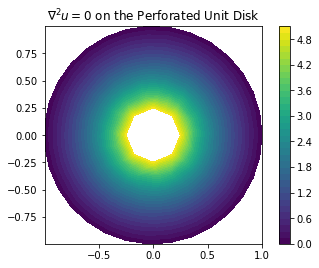

In [15]:
p = plot(wedge_sol)
plt.title(r'$∇ ^2 u = 0$ on the Perforated Unit Disk')
plt.colorbar(p)
plt.show()

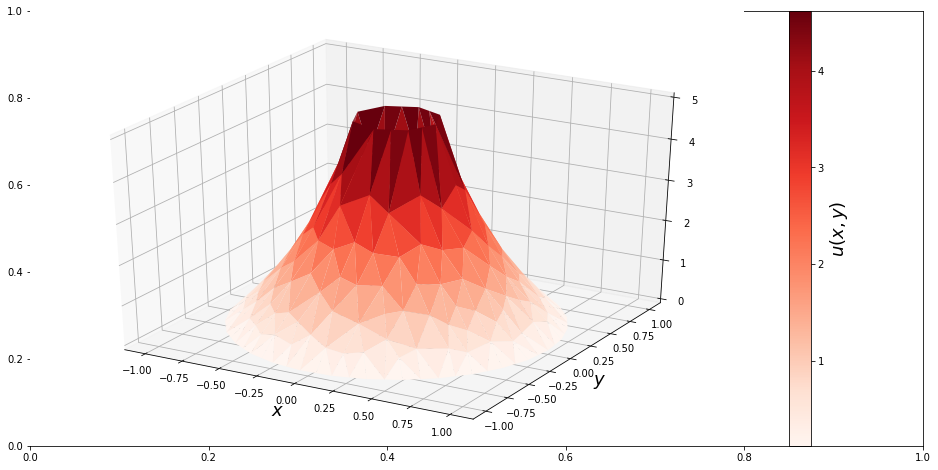

In [16]:
triangulation = mesh_triangulation(wedge_mesh)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
c = ax.plot_trisurf(triangulation, np.array(wedge_sol.vector()),cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax)
cb.set_label(r"$u(x, y)$", fontsize=18)
